### 10-701 Machine Learning Project
# Image Caption Generation

Team 26  
Olivier Filion  
Michael Agaby  
Nicholas Amano  

All Imports: I'm copy pasting all imports here to stay organized

In [16]:
import sys
print(sys.version)
import json
import os
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from collections import defaultdict
import statistics

3.9.2 (tags/v3.9.2:1a79785, Feb 19 2021, 13:44:55) [MSC v.1928 64 bit (AMD64)]


## Utility Functions

In [17]:
import json
import os

def load_captions(path):
    with open(path, "r") as json_file:
        json_dict = json.load(json_file)
    captions = {}
    for annotation in json_dict["annotations"]:
        image_id = annotation["image_id"]
        if image_id not in captions:
            captions[image_id] = []
        captions[image_id].append(annotation["caption"])
    return captions

train_captions = load_captions(os.path.join("dataset", "annotations", "annotations", "captions_train2017.json"))
val_captions = load_captions(os.path.join("dataset", "annotations", "annotations", "captions_val2017.json"))
print(val_captions[139]) 

['A woman stands in the dining area at the table.', 'A room with chairs, a table, and a woman in it.', 'A woman standing in a kitchen by a window', 'A person standing at a table in a room.', 'A living area with a television and a table']


In [30]:
from torchtext.data.utils import get_tokenizer

PUNCTUATION = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'
PUNCTUATION_TRANS = str.maketrans("", "", PUNCTUATION)

tokenizer = get_tokenizer("basic_english")
def preprocess_captions(captions):
    preprocessed_captions = {}
    for image_id in captions:
        preprocessed_captions[image_id] = []
        for caption in captions[image_id]:
            #caption = caption.translate(PUNCTUATION_TRANS)
            caption = "<start> " + caption.lower().strip() + " <end>"
            caption = tokenizer(caption)
            preprocessed_captions[image_id].append(caption)
    return preprocessed_captions

preprocessed_train_captions = preprocess_captions(train_captions)
preprocessed_val_captions = preprocess_captions(val_captions)
print(preprocessed_val_captions[139])

[['<start>', 'a', 'woman', 'stands', 'in', 'the', 'dining', 'area', 'at', 'the', 'table', '.', '<end>'], ['<start>', 'a', 'room', 'with', 'chairs', ',', 'a', 'table', ',', 'and', 'a', 'woman', 'in', 'it', '.', '<end>'], ['<start>', 'a', 'woman', 'standing', 'in', 'a', 'kitchen', 'by', 'a', 'window', '<end>'], ['<start>', 'a', 'person', 'standing', 'at', 'a', 'table', 'in', 'a', 'room', '.', '<end>'], ['<start>', 'a', 'living', 'area', 'with', 'a', 'television', 'and', 'a', 'table', '<end>']]


In [31]:
from torchtext.vocab import build_vocab_from_iterator

def create_vocabulary(tokenized_captions):
    all_tokens = []
    for image_id in tokenized_captions:
        for caption in tokenized_captions[image_id]:
            all_tokens += caption
    return build_vocab_from_iterator([all_tokens], min_freq=1, specials=["<unk>", "<null>"])

vocabulary = create_vocabulary(preprocessed_train_captions)
print(len(vocabulary))

28940


In [32]:
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Resize, CenterCrop
from functools import lru_cache

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

class CaptionDataset(Dataset):

    def __init__(self, image_folder, preprocessed_captions, vocab, max_caption_length=22):
        self.image_folder = image_folder
        self.captions = preprocessed_captions
        self.vocab = vocab
        self.indices = [(image_id, caption_id)
                        for image_id in preprocessed_captions
                        for caption_id in range(len(preprocessed_captions[image_id]))
                        if len(preprocessed_captions[image_id][caption_id]) <= max_caption_length]
        self.tensor_transform = ToTensor()
        self.scale_transform = Resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        self.max_caption_length = max_caption_length # includes <start> and <end> tokens, captions shorter than this will be padded with <null> tokens
    
    def __len__(self):
        return len(self.indices)

    @lru_cache(maxsize=128)
    def _get_image(self, image_id, crop_and_scale):
        image_str = str(image_id)
        image_filename = "0" * (12 - len(image_str)) + image_str + ".jpg"
        image_path = os.path.join(self.image_folder, image_filename)
        image = Image.open(image_path)

        if crop_and_scale:
            crop_transform = CenterCrop((min(image.size), min(image.size)))
            image = crop_transform(image)
            image = self.scale_transform(image)
        return self.tensor_transform(image)

    def __getitem__(self, idx, crop_and_scale=True):
        image_id, caption_id = self.indices[idx]
        
        image_tensor = self._get_image(image_id, crop_and_scale)

        caption = self.captions[image_id][caption_id]
        labels = torch.zeros(self.max_caption_length, 1)
        for i in range(self.max_caption_length):
            token = ("<null>" if i >= len(caption)
                     else caption[i] if caption[i] in self.vocab
                     else "<unk>")
            labels[i][0] = self.vocab[token]
        return image_tensor, labels
  

# Visualizing Some Data

torch.Size([3, 256, 256])
tensor([[4.0000e+00],
        [2.0000e+00],
        [3.5600e+02],
        [3.8110e+03],
        [9.0000e+00],
        [2.0000e+00],
        [8.3000e+01],
        [1.2200e+02],
        [7.0000e+00],
        [4.0000e+01],
        [1.0880e+03],
        [3.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00]])
['<start>', 'a', 'bicycle', 'replica', 'with', 'a', 'clock', 'as', 'the', 'front', 'wheel', '<end>']


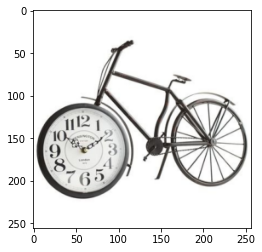

In [22]:
import matplotlib.pyplot as plt

train_ds = CaptionDataset(os.path.join("dataset", "train", "train2017"), preprocessed_train_captions, vocabulary)

im, l = train_ds[0]
print(im.shape)
print(l)

print(preprocessed_train_captions[train_ds.indices[0][0]][train_ds.indices[0][1]])

plt.imshow(im.permute((1, 2, 0)))
plt.show()

['<start>', 'a', 'car', 'that', 'seems', 'to', 'be', 'parked', 'illegally', 'behind', 'a', 'legally', 'parked', 'car', '<end>']
['<start>', 'two', 'cars', 'parked', 'on', 'the', 'sidewalk', 'on', 'the', 'street', '<end>']
['<start>', 'city', 'street', 'with', 'parked', 'cars', 'and', 'a', 'bench', '<end>']
['<start>', 'cars', 'try', 'to', 'maneuver', 'into', 'parking', 'spaces', 'along', 'a', 'densely', 'packed', 'city', 'street', '<end>']
['<start>', 'a', 'couple', 'of', 'cars', 'parked', 'in', 'a', 'busy', 'street', 'sidewalk', '<end>']


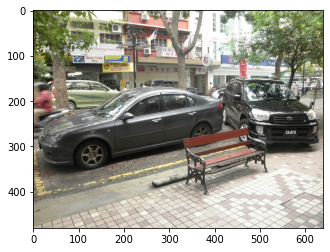

In [23]:
# an example of all 5 captions for one image
im, l = train_ds.__getitem__(10, False)
print(preprocessed_train_captions[train_ds.indices[10][0]][0])
print(preprocessed_train_captions[train_ds.indices[10][0]][1])
print(preprocessed_train_captions[train_ds.indices[10][0]][2])
print(preprocessed_train_captions[train_ds.indices[10][0]][3])
print(preprocessed_train_captions[train_ds.indices[10][0]][4])
plt.imshow(im.permute((1, 2, 0)))
plt.show()

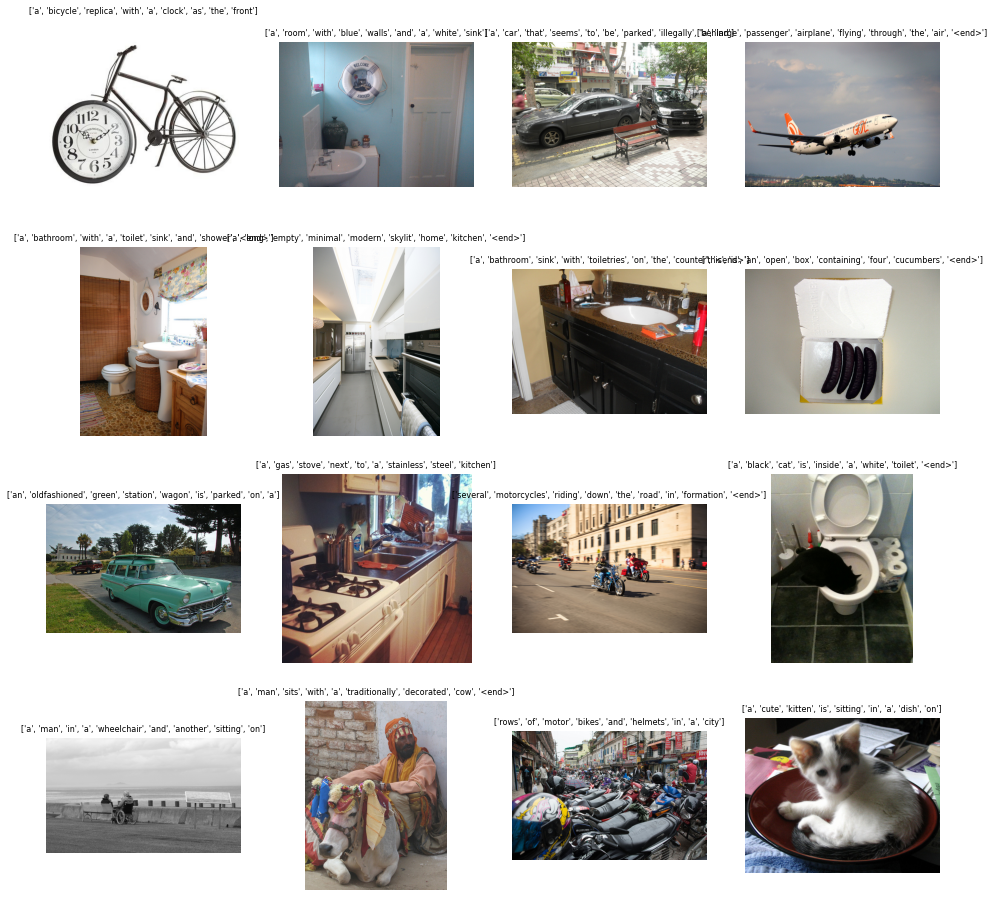

In [24]:
# 16 images as well as the first few wordsw of one of their captions
plt.subplots(figsize=(16,16))

for i in range(16):
    im, l = train_ds.__getitem__(5*i, False)
    plt.subplot(4,4,i+1)
    plt.title(preprocessed_train_captions[train_ds.indices[5*i][0]][0][1:10], fontsize=8)
    plt.imshow(im.permute((1, 2, 0)))
    plt.axis("off")
plt.show()

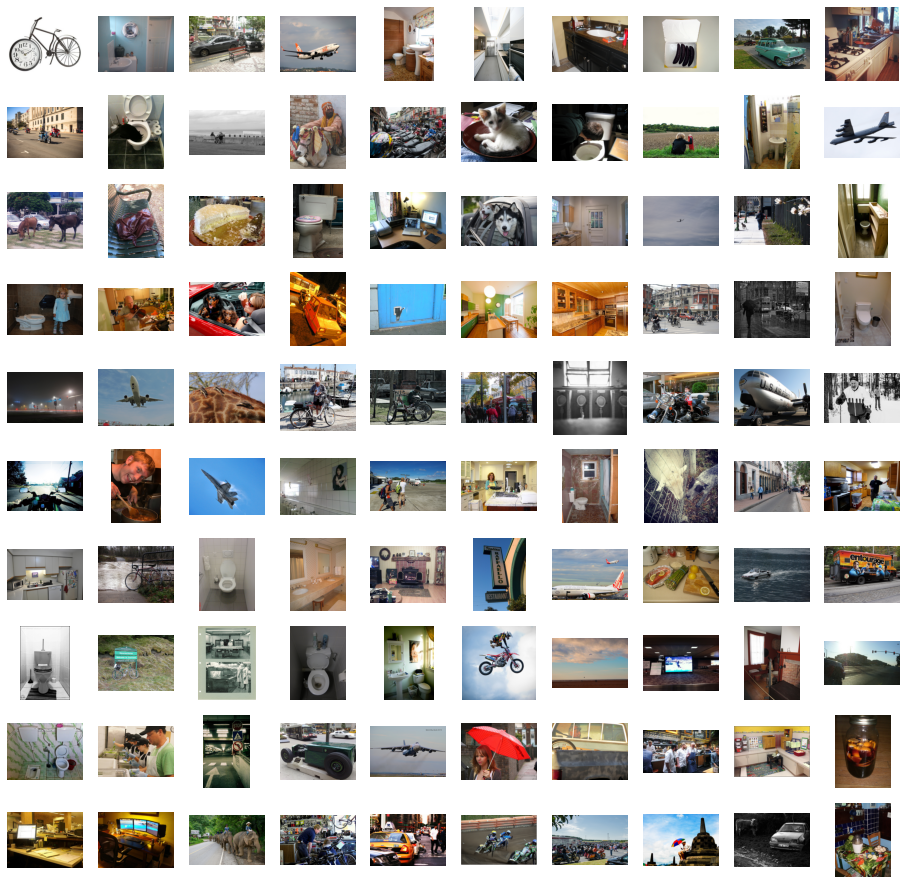

In [25]:
# first 100 images:
plt.subplots(figsize=(16,16))

for i in range(100):
    im, l = train_ds.__getitem__(5*i, False)
    plt.subplot(10,10,i+1)
    plt.imshow(im.permute((1, 2, 0)))
    plt.axis("off")
plt.show()

### Aspect Ratios

Estimating the histogram of aspect ratios by random sampling

0
10000
20000
30000
40000


(array([ 16.,  63., 148., 176., 136., 145., 112., 113., 122., 111.,  66.,
         54.,  36.,  26.,  24.,  22.,  12.,  11.,   9.,   9.,   7.,   9.,
          4.,   3.,   3.,   3.,   2.,   3.,   1.,   2.,   1.,   2.,   1.,
          0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.]),
 array([0.328125  , 0.45207651, 0.57602803, 0.69997954, 0.82393106,
        0.94788257, 1.07183408, 1.1957856 , 1.31973711, 1.44368863,
        1.56764014, 1.69159165, 1.81554317, 1.93949468, 2.06344619,
        2.18739771, 2.31134922, 2.43530074, 2.55925225, 2.68320376,
        2.80715528, 2.93110679, 3.05505831, 3.17900982, 3.30296133,
        3.42691285, 3.55086436, 3.67481588, 3.79876739, 3.9227189 ,
        4.04667042, 4.17062193, 4.29457345, 4.41852496, 4.54247647,
        4.66642799, 4.7903795 , 4.91433101, 5.03828253, 5.16223404,
        5.28618556, 5.41013707, 5.53408858, 5.6580401 , 5.78199161,
        5.90594313, 6.02989464, 6.15384615]),
 <BarContainer obj

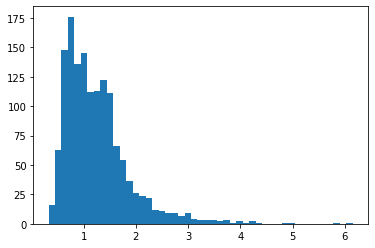

In [11]:
from collections import defaultdict
import random

ratios = defaultdict(float)

for i in range(50000):
    indx = random.randint(0, len(train_ds))
    if(i%10000==0):
        print(i)
    im, l = train_ds.__getitem__(indx, False)
    h, w = im.shape[1], im.shape[2]
    ratios[w/h]+=1
plt.hist(ratios, bins='auto') 

### Area

Estimating histogram of area by random sampling


0
10000
20000
30000
40000


(array([1460.,   19.,   22.,   45.,   76.,  124.,  117.,  129.,  110.,
         114.,   72.,   55.,   50.,   45.,   44.,   44.]),
 array([3.28125000e-01, 2.56003076e+04, 5.12002871e+04, 7.68002666e+04,
        1.02400246e+05, 1.28000226e+05, 1.53600205e+05, 1.79200185e+05,
        2.04800164e+05, 2.30400144e+05, 2.56000123e+05, 2.81600103e+05,
        3.07200082e+05, 3.32800062e+05, 3.58400041e+05, 3.84000021e+05,
        4.09600000e+05]),
 <BarContainer object of 16 artists>)

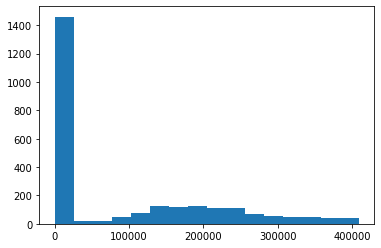

In [12]:
areas = defaultdict(float)

for i in range(50000):
    indx = random.randint(0, len(train_ds))
    if(i%10000==0):
        print(i)
    im, l = train_ds.__getitem__(indx, False)
    h, w = im.shape[1], im.shape[2]
    ratios[h*w]+=1
plt.hist(ratios, bins='auto') 

### Finding the most common words 

In [26]:
counts = defaultdict(int)

for captions in preprocessed_train_captions.values():
    for caption in captions:
        for word in caption:
            counts[word]+=1
        
    

In [27]:
sorted_counts = sorted(counts, key=counts.get, reverse=True)
conjuncts = ['has','small','while','some','down','to','<start>','<end>','a','.','on','of','the','in','with','and', 'is', 'an', 'two', 'one', 'at', 'are', 'next'
            ,'there','side','other','is', 'it', 'that','near', 'the', 'his', 'her', 'they', 'up', 'top', ',', ':', ';', '\''
            ,'by','large','front','back']

for word in conjuncts:
    if(word in sorted_counts):
        sorted_counts.remove(word)
    
print(sorted_counts[0:50])

['man', 'sitting', 'standing', 'people', 'white', 'woman', 'street', 'table', 'holding', 'person', 'group', 'field', 'tennis', 'black', 'train', 'plate', 'room', 'dog', 'riding', 'red', 'cat', 'young', 'water', 'baseball', 'playing', 'walking', 'bathroom', 'sign', 'blue', 'kitchen', 'food', 'grass', 'bus', 'pizza', 'green', 'parked', 'building', 'bed', 'looking', 'snow', 'beach', 'ball', 'couple', 'three', 'for', 'boy', 'men', 'toilet', 'clock', 'city']


### Distribution of caption lengths

['<start>', 'a', 'black', 'and', 'white', 'shot', 'shows', 'evergreens', ',', 'bare', 'shade', 'trees', ',', 'and', 'bushes', 'that', 'slightly', 'obstruct', 'the', 'view', 'of', 'a', 'building', 'with', 'a', 'low', 'roof', 'in', 'comparison', 'to', 'its', 'clock', 'tower', ',', 'which', 'stands', 'more', 'than', 'twice', 'as', 'tall', 'as', 'the', 'evergreens', ',', 'against', 'a', 'grey', 'sky', '.', '<end>']
['<start>', 'a', 'beautifully', 'maintained', 'park-like', 'area', 'with', 'rolling', 'green', 'slopes', 'has', 'lots', 'of', 'people', ',', 'some', 'far', 'away', 'among', 'the', 'trees', ',', 'most', 'in', 'the', 'small', ',', 'windy', 'roads', 'to', 'and', 'from', 'the', 'trees', ',', 'including', 'two', 'people', 'with', 'a', 'buggy', ',', 'some', 'bike', 'riders', 'and', 'lots', 'of', 'walkers', '.', '<end>']
['<start>', 'a', 'dining', 'car', 'of', 'a', 'train', 'with', 'people', 'seated', 'in', 'the', 'furthest', 'half', ',', 'and', 'none', 'in', 'closest', 'half', ',', 'w

(array([2.29900e+03, 2.96990e+04, 1.02419e+05, 1.22734e+05, 1.14209e+05,
        8.22360e+04, 5.38810e+04, 3.22070e+04, 1.87450e+04, 1.11910e+04,
        7.09100e+03, 4.47500e+03, 2.90500e+03, 2.04300e+03, 1.45500e+03,
        9.81000e+02, 7.50000e+02, 5.79000e+02, 3.89000e+02, 2.78000e+02,
        2.18000e+02, 1.66000e+02, 1.12000e+02, 9.60000e+01, 8.30000e+01,
        5.80000e+01, 4.30000e+01, 5.60000e+01, 3.90000e+01, 3.40000e+01,
        4.10000e+01, 2.70000e+01, 2.20000e+01, 2.20000e+01, 1.00000e+01,
        9.00000e+00, 2.50000e+01, 1.80000e+01, 1.90000e+01, 1.50000e+01,
        1.30000e+01, 1.40000e+01, 8.00000e+00, 9.00000e+00, 1.00000e+01,
        7.00000e+00, 5.00000e+00, 1.00000e+00, 2.00000e+00, 5.00000e+00]),
 array([ 6.  ,  7.02,  8.04,  9.06, 10.08, 11.1 , 12.12, 13.14, 14.16,
        15.18, 16.2 , 17.22, 18.24, 19.26, 20.28, 21.3 , 22.32, 23.34,
        24.36, 25.38, 26.4 , 27.42, 28.44, 29.46, 30.48, 31.5 , 32.52,
        33.54, 34.56, 35.58, 36.6 , 37.62, 38.64, 39.66

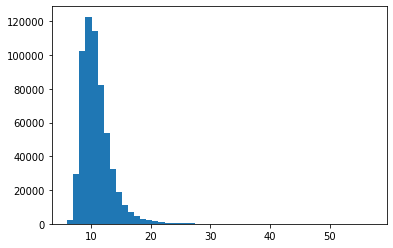

In [33]:
import statistics
lengths = []
for captions in preprocessed_train_captions.values():
    for caption in captions:
        lengths.append(len(caption)-2)
        if len(caption) == 51:
            print(caption)
        
print("Average caption length: ", sum(lengths)/len(lengths))
print("Median caption length: ", statistics.median(lengths))
print("Shortest caption length: ", min(lengths))
print("Longest caption length: ", max(lengths))
plt.hist(lengths, bins=max(lengths)) 

We see a clear right skew in the distribution of caption lengths